cuda
Users' Powers:[-13.454281 -30.943207 -24.49852  -37.66932  -14.917595] dBm ----->> SumPower : -10.867438316345215
Sigma2 Power:-40.0 dBm


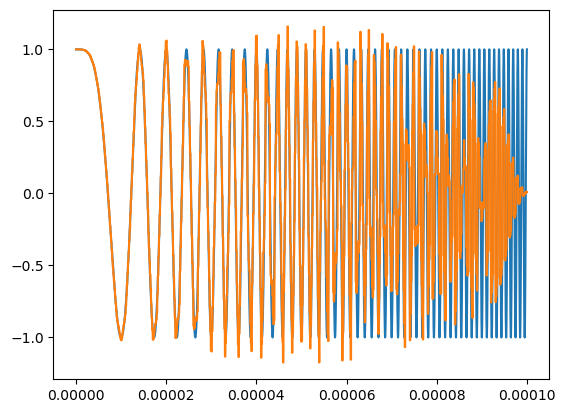

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from deap import base, creator, tools, algorithms
from deap.tools import Statistics
from pulses import RadarPulseGenerator, CommPulseGenerator, generate_walsh_matrix
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device = 'cpu'
print(device)
t = torch.linspace(0, 1e-4, int(1e5), device=device)

mycdma_code = generate_walsh_matrix(8)*(-2) + 1

b = torch.tensor([+1, +1, +1, +1, +1, -1, -1, +1, +1, -1, +1, -1, +1], device=device)
# Define parameters
T = 1e-4       # Total duration of radar pulse (1e-4 seconds)
B = 1e6        # Bandwidth of radar pulse (1 MHz)
K = 5         # Number of users (OFDMA users)
L = 100        # Number of bits in radar pulse duration
Tb = T / L     # Duration of each bit interval
snr_db = 30
Ptotal_dbm = -30
comm_pulse_kind = 'CDMA'
radar_pulse_kind = 'LFM'

myCommPulses = CommPulseGenerator(t, Tb, T, device)
myRadarPulses = RadarPulseGenerator(t, T=T, device=device)
snr = 10**(snr_db/10)
Ptotal = 10**((Ptotal_dbm-30)/10)

if comm_pulse_kind=='OFDMA':
    g_funcs = lambda l, k: myCommPulses.OFDMA_pulse(l, k-1)
    sigma2 = L*Tb/snr

if comm_pulse_kind=='TDMA':
    g_funcs = lambda l, k: myCommPulses.TDMA_pulse(l, k, K)
    sigma2 = L*Tb/snr/K

if comm_pulse_kind=='CDMA':
    g_funcs = lambda l, k: myCommPulses.CDMA_pulse(l, mycdma_code[k-1, :])
    sigma2 = L*Tb/snr

if radar_pulse_kind=='LFM':
    radar_pulse = myRadarPulses.LFM_pulse(B)

if radar_pulse_kind=='Gaussian':
    radar_pulse = myRadarPulses.Gaussian_pulse(B)

g_vec = torch.zeros((L*K, len(t)), device=device, dtype=torch.complex64)
for l in range(L):
    for k in range(K):
        g_vec[l*K + k, :] = g_funcs(l, k+1)
user_bit_energy = torch.sum(torch.abs(g_vec)**2, dim=1).reshape((L, K)) * (t[1]-t[0])
user_energy = user_bit_energy.sum(dim=0)

Q = torch.matmul(g_vec, g_vec.conj().T)*(t[1]-t[0])

R = radar_pulse.repeat(K*L, 1)

G = torch.diag(torch.matmul(R, g_vec.conj().T))*(t[1]-t[0])

c_opt = torch.matmul(G, torch.inverse(Q))
s_opt = torch.sum(c_opt[:, torch.newaxis].repeat(1, len(t)) * g_vec, dim=0)
user_bit_energy = (torch.sum(torch.abs(g_vec)**2, dim=1) * torch.abs(c_opt)**2).reshape((L, K)) * (t[1]-t[0])
user_energy = user_bit_energy.sum(dim=0)
print(f'Users\' Powers:{10*torch.log10(user_energy).cpu().numpy()+30} dBm ----->> SumPower : {10*torch.log10(user_energy.sum()).cpu().numpy()+30}')
print(f'Sigma2 Power:{10*np.log10(sigma2)+30} dBm')

plt.figure()
plt.plot(t.cpu(), radar_pulse.cpu().real)
plt.plot(t.cpu(), s_opt.cpu().real)

cuda


0it [00:00, ?it/s]

Iteration 0: constraint value = 327.622, Dual Variable = 0.003, Cost = 1.988, UpdateDistance:0.10689657926559448
	----> sumRate = 46.800, MSE = 1.977
Iteration 1000: constraint value = -0.993, Dual Variable = 0.030, Cost = 0.032, UpdateDistance:0.0001470478600822389
	----> sumRate = 0.101, MSE = 0.062
Iteration 2000: constraint value = -0.996, Dual Variable = 0.020, Cost = 0.042, UpdateDistance:4.391996480990201e-05
	----> sumRate = 0.058, MSE = 0.062
Iteration 3000: constraint value = -0.997, Dual Variable = 0.011, Cost = 0.052, UpdateDistance:1.9243825590820052e-05
	----> sumRate = 0.046, MSE = 0.062


1it [11:38, 698.03s/it]

Early Stopping
====END 3869: constraint value = -0.997, Dual Variable = 0.002, Cost = 0.060, UpdateDistance:3.552517569005431e-08
	----> sumRate = 0.043, MSE = 0.062
Users' Powers:[-58.38456  -58.385223 -71.20831  -75.7684   -78.71766 ] dBm ----->> SumPower : -55.204830169677734
Sigma2 Power:-40.0 dBm


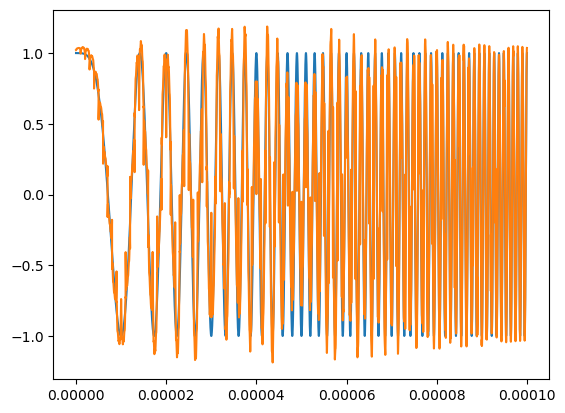

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from deap import base, creator, tools, algorithms
from deap.tools import Statistics
from pulses import RadarPulseGenerator, CommPulseGenerator, generate_walsh_matrix
import torch
from multiprocessing import Pool
from tqdm import tqdm

device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device = 'cpu'
print(device)
t = torch.linspace(0, 1e-4, int(1e4), device=device)

mycdma_code = generate_walsh_matrix(8)*(-2) + 1

b = torch.tensor([+1, +1, +1, +1, +1, -1, -1, +1, +1, -1, +1, -1, +1], device=device)
# Define parameters
T = 1e-4       # Total duration of radar pulse (1e-4 seconds)
B = 1e6        # Bandwidth of radar pulse (1 MHz)
K = 5          # Number of users (OFDMA users)
L = 100        # Number of bits in radar pulse duration
Tb = T / L     # Duration of each bit interval

myCommPulses = CommPulseGenerator(t, Tb, T, device)
myRadarPulses = RadarPulseGenerator(t, T=T, device=device)

g_funcs = lambda l, k: myCommPulses.OFDMA_pulse(l, k-1)
# g_funcs = lambda l, k: myCommPulses.TDMA_pulse(l, k, K)
# g_funcs = lambda l, k: myCommPulses.CDMA_pulse(l, mycdma_code[k-1, :])

radar_pulse = myRadarPulses.LFM_pulse(B)
# radar_pulse = myRadarPulses.Gaussian_pulse(B)
radar_power = torch.sum(torch.abs(radar_pulse)**2)*(t[1]-t[0])

g_vec = torch.zeros((L*K, len(t)), device=device, dtype=torch.complex64)
for l in range(L):
    for k in range(K):
        g_vec[l*K + k, :] = g_funcs(l, k+1)

def total_max_power_constr(coff):
     return torch.sum(torch.abs(coff)**2) - Ptotal/Tb

def get_mse(coff):
    s = torch.sum(coff[:, None] * g_vec, dim=0)
    s = s / torch.sqrt(torch.mean(s.abs()**2))
    return torch.mean(torch.abs(s - radar_pulse / torch.sqrt(torch.mean(radar_pulse.abs()**2))) ** 2) # Compute MSE loss
    # return torch.mean(torch.abs(s - radar_pulse) ** 2) # Compute MSE loss

def get_gamma(coff):
    return (torch.abs(coff)**2).reshape((L, K)).sum(dim=0) * Tb / sigma2 #for OFDMA and CDMA

# Fitness function
def cost_function(coff, coff_old, dual_lambda, theta):
    """
    Compute the fitness (MSE) for the given coefficients.

    Parameters:
    - individual (torch.Tensor): Coefficients of size (L * K,).

    Returns:
    - mse (float): Mean squared error between synthesized and radar pulses.
    """

    sumrate = torch.sum(torch.log2(1 + get_gamma(coff)))
    sumrate_old = torch.sum(torch.log2(1 + get_gamma(coff_old)))
    return theta*get_mse(coff) - (1-theta)*sumrate+ dual_lambda*(total_max_power_constr(coff))

# Initialize individual with real and imaginary parts
init_c = torch.rand(K * L * 2, device=device, requires_grad=True) * 2 - 1
real_val = init_c[:len(init_c)//2]  # Real part
imag_val = init_c[len(init_c)//2:]  # Imaginary part
# Combine real and imaginary parts into complex tensor
c = real_val + 1j * imag_val  # Combine parts to form a complex number

c.retain_grad()

dual = 0
dual_update_rate = 1e-5
Theta = np.linspace(0,1,21)
Theta = [1]
MSEs = np.zeros(len(Theta))
SumRates = np.zeros(len(Theta))
for idx, theta in tqdm(enumerate(Theta)):
    primal_update_rate = 1e-4
    for itr in range(100000):

        # Call the fitness function with the complex individual
        c_old = c.detach()
        cost = cost_function(c, c_old, dual, theta)
        
        # Backpropagate to compute gradients
        cost.backward(retain_graph=True)
        delta_x = -c.grad
        t_coff = 1
        alpha = 0.005
        beta = 0.9

        with torch.no_grad():
            loop_cont = 0
            for _ in range(1000):
                loop_cont += 1
                new_cost = cost_function(c + t_coff*delta_x, c_old, dual, theta).item()
                old_cost = cost.item()
                if new_cost <= old_cost - alpha*t_coff*torch.sum(delta_x.abs()**2):
                    break
                else:
                    t_coff *= beta

            if torch.linalg.norm(t_coff * delta_x) < 1e-6:
                print("Early Stopping")
                break
            
            c += t_coff * delta_x  # Update rule
            dual = max(0, dual + dual_update_rate * total_max_power_constr(c))
            
            if itr % 1000 == 0:
                print(f"Iteration {itr}: constraint value = {total_max_power_constr(c).item():0.3f}, Dual Variable = {dual:0.3f}, Cost = {cost.item():0.3f}, UpdateDistance:{torch.linalg.norm(t_coff * delta_x)}")
                print(f'\t----> sumRate = {torch.sum(torch.log2(1 + get_gamma(c))).item():0.3f}, MSE = {get_mse(c).item():0.3f}')    

        c.grad.zero_()
    

    c_opt = c.detach()
    s_opt = torch.sum(c_opt[:, None] * g_vec, dim=0)
    MSEs[idx] = get_mse(c_opt).item()
    SumRates[idx] = torch.sum(torch.log2(1 + get_gamma(c_opt))).cpu().numpy()
    print(f"====END {itr}: constraint value = {total_max_power_constr(c_opt).item():0.3f}, Dual Variable = {dual:0.3f}, Cost = {cost.item():0.3f}, UpdateDistance:{torch.linalg.norm(t_coff * delta_x)}")
    print(f'\t----> sumRate = {SumRates[idx]:0.3f}, MSE = {MSEs[idx]:0.3f}')  
    user_bit_energy = (torch.sum(torch.abs(g_vec)**2, dim=1) * torch.abs(c_opt)**2).reshape((L, K)) * (t[1]-t[0])
    user_energy = user_bit_energy.sum(dim=0)
    print(f'Users\' Powers:{10*torch.log10(user_energy).cpu().numpy()+30} dBm ----->> SumPower : {10*torch.log10(user_energy.sum()).cpu().numpy()+30}')
    print(f'Sigma2 Power:{10*np.log10(sigma2)+30} dBm')

    plt.figure()
    plt.plot(t.cpu(), (radar_pulse/torch.sqrt(torch.mean(radar_pulse.abs()**2))).cpu().real)
    plt.plot(t.cpu(), (s_opt/torch.sqrt(torch.mean(s_opt.abs()**2))).cpu().real)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from deap import base, creator, tools, algorithms
from deap.tools import Statistics
from pulses import RadarPulseGenerator, CommPulseGenerator, generate_walsh_matrix
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device = 'cpu'
print(device)
t = torch.linspace(0, 1e-4, int(1e4), device=device)

mycdma_code = generate_walsh_matrix(8)*(-2) + 1

b = torch.tensor([+1, +1, +1, +1, +1, -1, -1, +1, +1, -1, +1, -1, +1], device=device)
# Define parameters
T = 1e-4       # Total duration of radar pulse (1e-4 seconds)
B = 1e6        # Bandwidth of radar pulse (1 MHz)
K = 5          # Number of users (OFDMA users)
L = 100        # Number of bits in radar pulse duration
Tb = T / L     # Duration of each bit interval

myCommPulses = CommPulseGenerator(t, Tb, T, device)
myRadarPulses = RadarPulseGenerator(t, T=T, device=device)

g_funcs = lambda l, k: myCommPulses.OFDMA_pulse(l, k-1)
# g_funcs = lambda l, k: myCommPulses.TDMA_pulse(l, k, K)
# g_funcs = lambda l, k: myCommPulses.CDMA_pulse(l, mycdma_code[k-1, :])

radar_pulse = myRadarPulses.LFM_pulse(B)
radar_power = torch.sum(torch.abs(radar_pulse)**2)*(t[1]-t[0])
g_vec = torch.zeros((L*K, len(t)), device=device, dtype=torch.complex64)
for l in range(L):
    for k in range(K):
        g_vec[l*K + k, :] = g_funcs(l, k+1)

# Fitness function
def fitness_fn(individual):
    """
    Compute the fitness (MSE) for the given coefficients.

    Parameters:
    - individual (torch.Tensor): Coefficients of size (L * K,).

    Returns:
    - mse (float): Mean squared error between synthesized and radar pulses.
    """
    N = len(individual) // 2
    # individual = np.clip(individual, -1, 1)
    real_val = torch.tensor(individual[:N], device=device, dtype=torch.float32)
    imag_val = torch.tensor(individual[N:], device=device, dtype=torch.float32)
    
    # Combine real and imaginary parts into complex tensor
    c_opt = real_val + 1j * imag_val
    c_opt = c_opt.to(torch.complex64)
    s_opt = torch.sum(c_opt[:, None] * g_vec, dim=0)
    s_opt_normalized = s_opt
    radar_pulse_normalized = radar_pulse
    mse = (torch.mean(torch.abs(s_opt_normalized - radar_pulse_normalized) ** 2)).item()
    return mse,

# DEAP setup
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
toolbox.register("attr_float", np.random.uniform, -1, 1)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, L * K * 2)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("evaluate", fitness_fn)
toolbox.register("mate", tools.cxBlend, alpha=0.5)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=0.05, indpb=0.1)
toolbox.register("select", tools.selTournament, tournsize=20)

# Genetic algorithm execution
population = toolbox.population(n=500)
n_generations = 1000

stats = Statistics(lambda ind: ind.fitness.values)
stats.register("Avg", lambda a: np.mean(a))
stats.register("Min", lambda a: np.min(a))
# Run the genetic algorithm
result, log = algorithms.eaSimple(
    population, toolbox, cxpb=0.7, mutpb=0.2, ngen=n_generations, verbose=True, stats=stats
)

# Extract the best individual
best_individual = tools.selBest(population, k=1)[0]
N = len(best_individual) // 2
real_val = torch.tensor(best_individual[:N], device=device, dtype=torch.float32)
imag_val = torch.tensor(best_individual[N:], device=device, dtype=torch.float32)

# Combine real and imaginary parts into complex tensor
c_opt_optimized = real_val + 1j * imag_val
c_opt_optimized = c_opt_optimized.to(torch.complex64).to(device)

# Synthesize optimized signal
s_opt_optimized = torch.sum(c_opt_optimized[:, None] * g_vec, dim=0)

# Plot results
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(t.cpu(), radar_pulse.cpu().real, label="Radar Pulse (Desired)", alpha=0.7)
plt.plot(t.cpu(), s_opt_optimized.cpu().real, label="Optimized Radar Pulse (s_opt)", linestyle="--")
plt.legend()
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Radar Waveform Approximation")
# plt.ylim([-1,1])
plt.show()

plt.figure()
plt.plot(c_opt_optimized.cpu().real)
plt.plot(c_opt_optimized.cpu().imag)

In [ ]:
radar_pulse_power = (radar_pulse.abs()**2).sum()
s_opt_optimized2 = torch.sum(c_opt_optimized[:, None] * g_vec, dim=0) * torch.sqrt(radar_pulse_power / (s_opt_optimized.abs()**2).sum())

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(t.cpu(), radar_pulse.cpu().real, label="Radar Pulse (Desired)", alpha=0.7)
plt.plot(t.cpu(), s_opt_optimized2.cpu().real, label="Optimized Radar Pulse (s_opt)", linestyle="--")
plt.legend()
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Radar Waveform Approximation")
# plt.ylim([-1,1])
plt.show()

plt.figure()
plt.plot(c_opt_optimized.cpu().real)
plt.plot(c_opt_optimized.cpu().imag)

In [ ]:
plt.figure(figsize=(10, 6))
plt.grid()

# Plot the Pareto Front
plt.plot(-MSEs, SumRates, '*-', label="Pareto Front", color="b")

# Fill the area under the Pareto points
# plt.fill_between(-MSEs, SumRates, alpha=0.3, color="blue", label="Feasible Region")
# plt.ylim([1*min(SumRates), 1.05*max(SumRates)])
# Add labels, title, and legend
plt.xlabel("Negative MSE", fontsize=12)
plt.ylabel("Sumrate", fontsize=12)
plt.title("Pareto Front for Multi-Objective Optimization", fontsize=14)
plt.legend(fontsize=10)

# Show the plot
plt.tight_layout()
plt.show()


# Create a figure and primary y-axis
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot MSE (left y-axis)
ax1.plot(Theta, -MSEs, 'b*-', label="MSE")
ax1.set_xlabel('Theta', fontsize=12)
ax1.set_ylabel('MSE (Negative)', color='b', fontsize=12)
ax1.tick_params(axis='y', labelcolor='b', labelsize=10)
ax1.set_title("Trade-off Between MSE and Sumrate vs. Theta", fontsize=14)

# Create a secondary y-axis for Sumrate
ax2 = ax1.twinx()
ax2.plot(Theta, SumRates, 'r*--', label="Sumrate")
ax2.set_ylabel('Sumrate (bits/s/Hz)', color='r', fontsize=12)
ax2.tick_params(axis='y', labelcolor='r', labelsize=10)

# Add legends for both axes
ax1.legend(loc="upper left", fontsize=10, title="Left Axis")
ax2.legend(loc="upper right", fontsize=10, title="Right Axis")

# Add grid for clarity
ax1.grid(visible=True, which="major", linestyle="--", linewidth=0.5)

# Adjust layout and show the plot
fig.tight_layout()
plt.show()
